<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Main-Modules" data-toc-modified-id="Main-Modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Main Modules</a></span></li><li><span><a href="#Summarizer" data-toc-modified-id="Summarizer-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Summarizer</a></span><ul class="toc-item"><li><span><a href="#Remove-punctuation" data-toc-modified-id="Remove-punctuation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Remove punctuation</a></span></li><li><span><a href="#NLP-preprocess" data-toc-modified-id="NLP-preprocess-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>NLP preprocess</a></span></li><li><span><a href="#Calc-word-frequency" data-toc-modified-id="Calc-word-frequency-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Calc word frequency</a></span></li><li><span><a href="#Calculate-sentence-scores" data-toc-modified-id="Calculate-sentence-scores-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Calculate sentence scores</a></span></li><li><span><a href="#Main-summarizer-module" data-toc-modified-id="Main-summarizer-module-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Main summarizer module</a></span></li></ul></li><li><span><a href="#Trends" data-toc-modified-id="Trends-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trends</a></span><ul class="toc-item"><li><span><a href="#Module" data-toc-modified-id="Module-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Module</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Test</a></span></li></ul></li><li><span><a href="#Context-Recognition" data-toc-modified-id="Context-Recognition-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Context Recognition</a></span><ul class="toc-item"><li><span><a href="#Create-training-examples" data-toc-modified-id="Create-training-examples-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Create training examples</a></span></li><li><span><a href="#Spacy-model-creation" data-toc-modified-id="Spacy-model-creation-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Spacy model creation</a></span></li><li><span><a href="#Return-context" data-toc-modified-id="Return-context-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Return context</a></span></li><li><span><a href="#Convert-to-JSON" data-toc-modified-id="Convert-to-JSON-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Convert to JSON</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Test</a></span></li></ul></li><li><span><a href="#Unit-Tests" data-toc-modified-id="Unit-Tests-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Unit Tests</a></span><ul class="toc-item"><li><span><a href="#Conversations" data-toc-modified-id="Conversations-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Conversations</a></span></li><li><span><a href="#Context" data-toc-modified-id="Context-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Context</a></span></li><li><span><a href="#Summarizer" data-toc-modified-id="Summarizer-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Summarizer</a></span></li><li><span><a href="#Trends" data-toc-modified-id="Trends-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Trends</a></span></li></ul></li></ul></div>

# Main Modules

In [6]:
import csv
import datetime
import heapq
import json
import os.path
import pickle
import random
import re
import string
from collections import Counter
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import spacy
import tensorflow as tf
# from google.auth.transport.requests import Request
# from google_auth_oauthlib.flow import InstalledAppFlow
from nltk import ne_chunk
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from spacy import displacy

from wordcloud import WordCloud

# spacy.load('en_core_web_sm')

# from googleapiclient.discovery import build

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [25]:
import en_core_web_sm

# Summarizer

In [7]:
SCOPES = ['https://www.googleapis.com/auth/calendar_entry']

f = open('convotext.txt', 'r').read().lower()

#     f = re.sub(r'\s+', ' ', f)
no_of_lines = len(open('convotext.txt', 'r').readlines())
stop_words = set(
    stopwords.words('english') +
    ['i', 'he', 'me', 'she', 'it', 'them', 'her', 'him'])

## Remove punctuation

In [8]:
def remove_punc(sent):
    punctuations = '''!()-[]{};'"\,<>/?@#%^&*_~'''
    for x in sent:
        if x in punctuations:
            sent = sent.replace(x, " ")
    return sent

## NLP preprocess

In [9]:
def preprocess(sent):
    #
    sent = remove_punc(sent)
    sent = nltk.word_tokenize(sent, language='english')
    lemmatizer = WordNetLemmatizer()
    sent = [lemmatizer.lemmatize(x) for x in sent]
    sent = ' '.join(sent)
    filtered_sentence = [
        w for w in sent.split(' ') if not w.lower() in stop_words
    ]

    return ' '.join(filtered_sentence).lower()

## Calc word frequency

In [10]:
def weighted_freq(sent):
    word_frequencies = {}
    for word in sent:
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1

    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word] / maximum_frequncy)

    return word_frequencies

## Calculate sentence scores

In [11]:
def sent_score_calc(text, word_frequencies):
    sentence_list = nltk.sent_tokenize(text)
    sentence_scores = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                # if len(sent.split(' ')) < 10:
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word]
                else:
                    sentence_scores[sent] += word_frequencies[word]
    return sentence_scores

## Main summarizer module

In [12]:
def extractive_summary(f, docu):
    max_freq = weighted_freq(docu)
    sent_scores = sent_score_calc(f, max_freq)
    no_of_lines = len(docu.split('.'))
    summary_sentences = heapq.nlargest(int(no_of_lines / 3),
                                       sent_scores,
                                       key=sent_scores.get)
    # summary_sentences =sorted(sent_scores, key=sent_scores.get, reverse=True)[:int(no_of_lines/2)]

    summary = ' '.join(i.capitalize() for i in summary_sentences)
    # print(summary)
    return summary

In [13]:
" ".join(f.split("\n"))

"boss thank you all for coming today. first of all, i would like you all to meet mr. mark johnson. he is our new salesperson with the company.  here is my number 9003401119 and my email id is msubhaditya@gmail.com  i think mark has met everyone, oh, except for ann.  hello, mark. i am ann nice to meet you. i am a salesperson, too.  it's nice to meet you, ann maybe you can help to teach me about my new job.  sure. we can be a .team you help me, i'll help you.  that sounds good to me, too. now let's talk about business. linda, will you please take notes of our meeting for us?  sure, i have my pen and paper ready.  yes please book a meeting on tuesday 10pm.  i want to book a flight on 10 june 2019.  great. please read the notes of our last meeting for us.  okay. first, we talked about the budget for next year.  i will budget is getting smaller every year.  second, we talked about the new products we are going to selling.  she means the new products you and i will be selling.  o.k. third, w

In [14]:
extractive_summary(" ".join(f.split("\n")), docu=f)

"I have a sales graph i would like to show everyone. O.k. I am a salesperson, too. We can be a .team you help me, i'll help you. I want to book a flight on 10 june 2019.  great. I need a new typewriter. So if that line goes up, am i doing a good job? Here is my number 9003401119 and my email id is msubhaditya@gmail.com  i think mark has met everyone, oh, except for ann. Yes please book a meeting on tuesday 10pm. We have a few things to talk about today. Mark has a presentation he would like to give about his new job. First of all, i would like you all to meet mr. mark johnson. Sure, i have my pen and paper ready. I am ann nice to meet you. I will budget is getting smaller every year. She means the new products you and i will be selling. I'm afraid our customers will think our product is too expensive. I think that's all. Anyway, good job, ann. Don't forget, if you want me to buy something for your office, the deadline is tomorrow. Oh, yeah, o.k. I'm sure you and mark will do even bette

# Trends

## Module

In [94]:
def trends(js):
    js = js.split(' ')
    lis_trend = []
    for each in js:
        each = preprocess(each)
        lis_trend.extend(each.split(' '))
    lis_trend = [x for x in lis_trend if x not in stop_words]
    dict_trend = Counter(lis_trend)
    dict_trend['.'] = 0

    wordcloud = WordCloud(width=500,
                          height=500,
                          background_color='white',
                          stopwords=stop_words,
                          min_font_size=7).generate(' '.join(
                              list(set(lis_trend))))
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    plt.axis('off')
    plt.savefig('trends.png')

    return dict_trend.most_common(5)

## Test

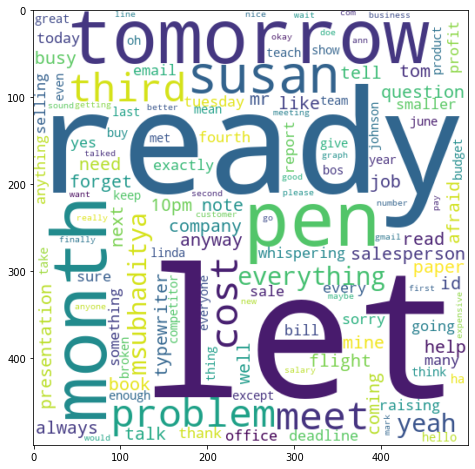

[('', 201), ('new', 7), ('product', 7), ('o.k', 7), ('mark', 5)]

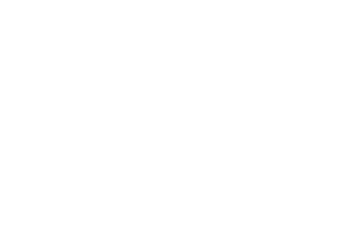

In [95]:
trends(f)

# Context Recognition

## Create training examples

In [96]:
def new_train_gen():
    # l = ['my no is 9003401119','is your phone 9341234441','your phone no is 8341934568','here is my no 8261348649','here is my no 6713401897']
    l = [
        "my email is ~msubhaditya@gmail.com",
        "is your email id ~rules@yahoo.com",
        "your email is ~aditya@rediff.com", "here is email ~bce@mail.com",
        "here is email id ~hello@find.in"
    ]
    s = ''
    for a in l:
        s += "[({},{},'EMAIL')]\n".format(
            re.search(r'~', a).start() + 1, len(a))
    print(s)

## Spacy model creation

In [97]:
def new_sp_model():
    TRAIN_DATA = [(u"my no is 9003401119", {
        "entities": [(9, 19, "PHONE")]
    }), (u"is your phone 9341234441", {
        "entities": [(14, 24, "PHONE")]
    }), (u"your phone number is 8341934568", {
        "entities": [(17, 27, "PHONE")]
    }), (u"here is my no 8261348649", {
        "entities": [(14, 24, "PHONE")]
    }), (u"here is my number 6713401897", {
        "entities": [(14, 24, "PHONE")]
    }),
        (u"my email is msubhaditya@gmail.com", {
            "entities": [(12, 34, "EMAIL")]
        }),
        (u"is your email id rules@yahoo.com", {
            "entities": [(17, 33, "EMAIL")]
        }),
        (u"your email is aditya@rediff.com", {
            "entities": [(14, 32, "EMAIL")]
        }),
        (u"here is email bce@mail.com", {
            "entities": [(14, 27, "EMAIL")]
        }),
        (u"here my email id hello@find.in", {
            "entities": [(17, 31, "EMAIL")]
        })]
    nlp = spacy.blank('en')
    # optimizer = nlp.begin_training()
    # for i in range(20):
    #     random.shuffle(TRAIN_DATA)
    #     for text, annotations in TRAIN_DATA:
    #         nlp.update([text], [annotations], sgd=optimizer)

    batches = spacy.util.minibatch(TRAIN_DATA)
    for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(texts, annotations)
    nlp.to_disk("newmod")

## Return context

In [98]:
def return_context(docu):

    nlp = spacy.load('newmod')
    doc = nlp(docu)
    fin_dic = {}
    for ent in doc.ents:
        fin_dic[ent.text] = ent.label_
    return json.dumps(fin_dic, sort_keys=True)

## Convert to JSON

In [99]:
def context_json(p):
    dic = json.loads(return_context(p))
    d_final = {'persons': [], 'phone': [], 'emails': [], 'date': []}
    d_final['phone'].extend(re.findall(r'\d{10}', p))
    d_final['emails'].extend(re.findall(r'\S+@\S+', p))

    for a in dic:
        if dic[a] == 'PERSON':
            d_final['persons'].append(a)
        if dic[a] == 'DATE':
            d_final['date'].append(a)
    l = []
    for a in d_final:
        l.append(d_final[a])

    pd.DataFrame({k: pd.Series(l)
                  for k, l in d_final.items()
                  }).to_csv('output.csv',
                            columns=['persons', 'phone', 'emails', 'date'])
    # print(json.dumps(d_final))
    return json.dumps(d_final)

## Test

In [100]:
context_json(f)

/home/subhaditya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


'{"persons": [], "phone": ["9003401119"], "emails": ["msubhaditya@gmail.com"], "date": []}'

- Usability test 
- Observe the user, while doing the task – Collect positive and negative comments about performing the task. 
- Prepare 5 test cases for each activity in your project and write the report in this format 


# Unit Tests

## Conversations

In [101]:
# conv1
conv1 = '''
    Good morning Hello!
    England PC Services. This is Sarah speaking.
    Sarah speaking.
    How can I help you? My email id is sarah@gmail.com
    

    Who’s calling, please?
    Could I take your name, please?
    Hello, caller. Could I have your name, please?


    Hello! This is Kevin Jelf calling.
    Hello, this is Kevin Jelf from Friend Tecnology Firm.
    My name is Kevin Jelf from England PC Services. 


    One moment, please.
    I’ll see if he is in or if Mr Steven is available.
    Please hold on. I will get you through him.
    Could you hold the line, please?
    Please, hold the line.
    Certainly, Mr Kevin. I’ll just put you through.
    Of course, Mr Jelf. I’ll just see if he’s available.
    Mr Jelf? Thank you for holding. I’m just putting you through to Mr Steven.
    I’ll put you through.
    I’ll connect you.
    I’m connecting you now.
'''

In [102]:
# conv2
conv2 = '''
Hello call us at 9124199910
Do you usually talk on the phone?
Yes, I do. It’s a good way to keep in touch.

What was your favorite phone conversation?
It was when I talked to my interviewer. He did give me the good news that I got the job.

When did you have the conversation?
I don’t remember exactly, but It’s been 2 years so far, I guess.

Who did you talk to?
I talked to the owner of the restaurant where I’m working as a cashier.

What did you talk about?
He offered me the position and congratulated me.

Why did you find the conversation interesting?
Actually, it was more exciting than interesting. I was waiting for it for so long, and finally, he did make it come true.

Do you prefer talking directly or talking on the phone?
Personally, talking directly is much better to me since it’s more lively and authentic.

Who do you usually talk to on the phone? What is your number?
I talk to my mom almost every day. I will be missing the conversation every evening with mom if one day she stops calling me. My number is 9103419991

What are the differences between talking directly and phoning?
Well, talking directly seems more exciting since you can see facial expression, eye contact while talking on the phone, you can only listen to the voice.


'''

In [103]:
# conv3
conv3 = '''


    Hello. Could I speak to Jack Parkins, please?
    Who's calling, please?
    This is Fred Blinkingham. I'm a friend of Jack's.
    Hold the line, please. I'll put your call through. (after a moment)—I'm afraid he's out at the moment. Can I take a message?
    Yes. Can you ask him to give me a call? My number is 9093458965
    Could you repeat that, please?
    Certainly. That's 9093458965
    OK. I'll make sure Mr. Parkins gets your message.
    hank you. Goodbye.
    Goodbye.



'''

In [104]:
# conv4
conv4 = '''



    Dr. Peterson's office. How may I help you?
    I'd like to make an appointment to see the doctor.
    Certainly, are you ill at the moment?
    Yes, I'm not feeling very well.
    Do you have a fever or any other symptoms?
    Yes, I have a slight fever and aches and pains.
    OK, Dr. Peterson can see you tomorrow. Can you come in the morning?
    Yes, tomorrow morning is fine.
    How about 10 o'clock?
    Yes, 10 o'clock is fine.
    May have your name?
    Yes, it's David Lain.
    Have you seen Dr. Peterson before?
    Yes, I had a physical exam last year.
    Yes, here you are. OK, I've scheduled for 10 o'clock tomorrow morning.
    Thank you.
    Drink plenty of warm fluids and get a good night's sleep.
    Thank you. I'll do my best. Goodbye. Call if you need us 9144119930
    Goodbye.



'''

In [105]:
# conv5
conv5 = '''




    Good morning, Washington Grade School, this is Chris. How may I help you?
    Good morning, this is Alice Smith, I'm calling for my daughter, Judy. She's not feeling well today.
    I'm sorry to hear that. I hope it's not too bad.
    No, no she has a little fever and a cough. Nothing too serious.
    Well, I hope she feels well soon.
    Thank you. Do you think I could get her homework for today? Can you send it to my email? subhaditya@vit.in
    Is there any specific class?
    I'm especially concerned about math and science.
    OK, is it all right for me to give your email address to the teachers? They can then send the homework along later today.
    That would be great. Do you have my e-mail on file?
    Just a moment... We have chrisp@gmail.com. Is that correct?
    Yes, that is correct.
    OK, I'll make sure Mr. Brown and Ms. White get your message and email.
    Thank you very much.
    I hope Judy feels well soon.
    he should be fine by tomorrow. Thanks for your help.
    My pleasure, have a nice day.
    Thank you. Goodbye.
    Goodbye.



'''

## Context

In [106]:
# test1
context_json(conv1)

/home/subhaditya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


'{"persons": [], "phone": [], "emails": ["sarah@gmail.com"], "date": []}'

In [107]:
# test2
# test1
context_json(conv2)

/home/subhaditya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


'{"persons": [], "phone": ["9124199910", "9103419991"], "emails": [], "date": []}'

In [108]:
# test3
# test1
context_json(conv3)

/home/subhaditya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


'{"persons": [], "phone": ["9093458965", "9093458965"], "emails": [], "date": []}'

In [109]:
# test4
# test1
context_json(conv4)

/home/subhaditya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


'{"persons": [], "phone": ["9144119930"], "emails": [], "date": []}'

In [110]:
# test5
# test1
context_json(conv5)

/home/subhaditya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


'{"persons": [], "phone": [], "emails": ["subhaditya@vit.in", "chrisp@gmail.com."], "date": []}'

## Summarizer 

In [111]:
# test1

extractive_summary(" ".join(conv1.split("\n")), docu=conv1)

'I’ll just see if he’s available. I’m just putting you through to mr steven. I’m connecting you now. I’ll see if he is in or if mr steven is available. I’ll just put you through. I’ll put you through. I’ll connect you.'

In [112]:
# test2
extractive_summary(" ".join(conv2.split("\n")), docu=conv2)

'I don’t remember exactly, but it’s been 2 years so far, i guess. I talked to the owner of the restaurant where i’m working as a cashier. It’s a good way to keep in touch. I was waiting for it for so long, and finally, he did make it come true.'

In [113]:
# test3
extractive_summary(" ".join(conv3.split("\n")), docu=conv3)

"I'm a friend of jack's. Can i take a message? (after a moment)—i'm afraid he's out at the moment. Can you ask him to give me a call? I'll put your call through."

In [114]:
# test4
extractive_summary(" ".join(conv4.split("\n")), docu=conv4)

"Yes, i have a slight fever and aches and pains. Yes, i had a physical exam last year. Drink plenty of warm fluids and get a good night's sleep. Yes, i'm not feeling very well. Ok, i've scheduled for 10 o'clock tomorrow morning. Do you have a fever or any other symptoms? I'd like to make an appointment to see the doctor."

In [115]:
# test5
extractive_summary(" ".join(conv5.split("\n")), docu=conv5)

"No, no she has a little fever and a cough. Good morning, this is alice smith, i'm calling for my daughter, judy. My pleasure, have a nice day. Just a moment... we have chrisp@gmail.com. Well, i hope she feels well soon. Ok, i'll make sure mr. brown and ms. white get your message and email. I'm sorry to hear that. I hope it's not too bad. I'm especially concerned about math and science. I hope judy feels well soon."

## Trends

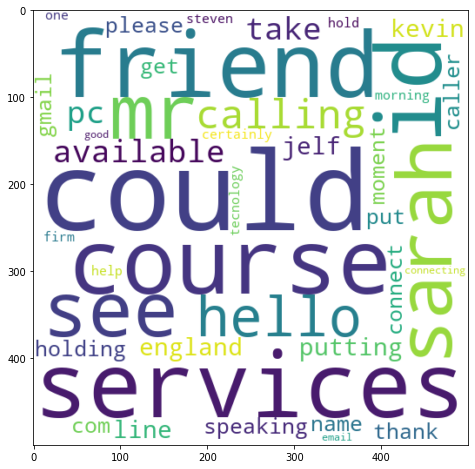

[('', 117), ('’', 9), ('please', 7), ('jelf', 5), ('mr', 5)]

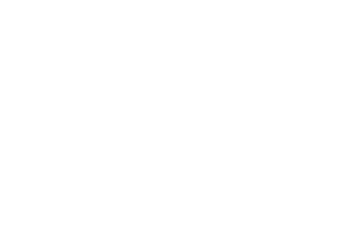

In [116]:
# test1
trends(conv1)

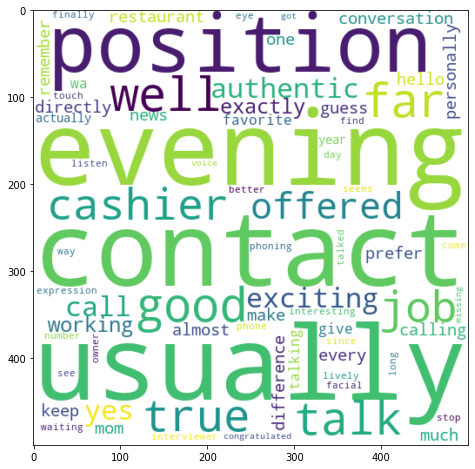

[('', 102), ('talking', 6), ('talk', 5), ('phone', 5), ('’', 5)]

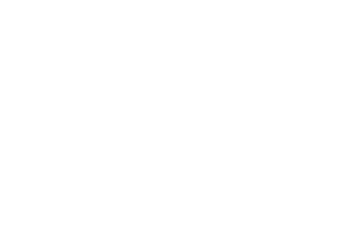

In [117]:
# test2
trends(conv2)

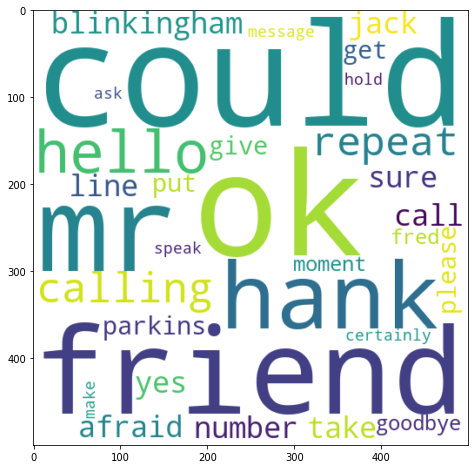

[('', 64), ('please', 4), ('could', 2), ('jack', 2), ('parkins', 2)]

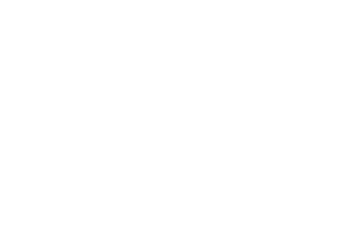

In [118]:
# test3
trends(conv3)

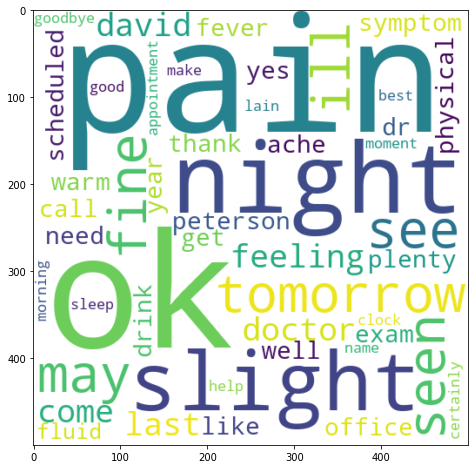

[('', 116), ('yes', 7), ('dr', 3), ('peterson', 3), ('tomorrow', 3)]

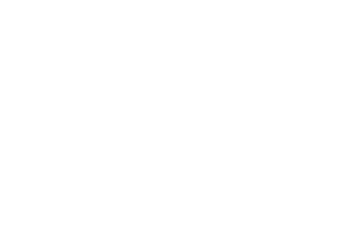

In [119]:
# test4
trends(conv4)

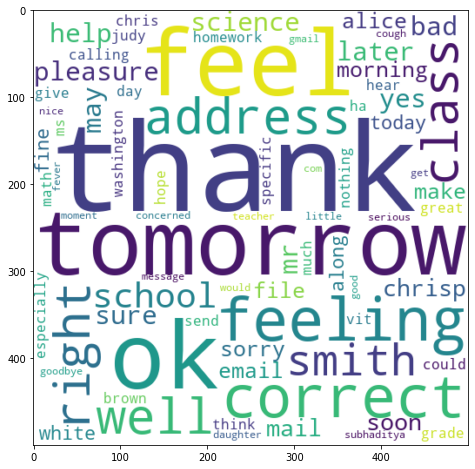

[('', 145), ('well', 4), ('today', 3), ('hope', 3), ('thank', 3)]

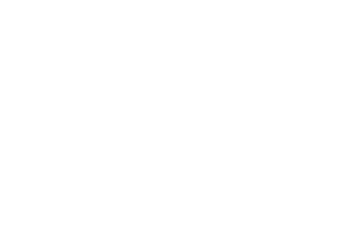

In [120]:
# test5
trends(conv5)